In [1]:
import numpy as np 

# Set seed values
seed = 42
#random.seed = seed
np.random.seed(seed=seed)

In [2]:
train_images = '/home/ec2-user/SageMaker/project/ACDC/train_image/'
train_mask   = '/home/ec2-user/SageMaker/project/ACDC/train_mask/'
val_images   = '/home/ec2-user/SageMaker/project/ACDC/val_image/'
val_mask     = '/home/ec2-user/SageMaker/project/ACDC/val_mask/'
s3_train_msk = 'data/raw/daily/raw/DataGuido/train_label/'


## LOADING DATA FROM S3 (no usar)

In [3]:
import boto3

_BUCKET_NAME = 'shipping-ml'
_PREFIX = 'data/raw/daily/raw/DataGuido/train_image/'
_BUFFER = 1000

s3 = boto3.resource('s3')
my_bucket = s3.Bucket(_BUCKET_NAME)

def ListFiles(my_bucket, buffer=_BUFFER):
    lista_archivos = []
    i = 0
    for object_summary in my_bucket.objects.filter(Prefix="data/raw/daily/raw/DataGuido/train_image/"):
        lista_archivos.append(object_summary.key)
        #print(object_summary.key)
        i = i + 1
        if i % buffer == 0:
            temp = lista_archivos
            lista_archivos = []
            print('fin ciclo')
            i = 0
            yield temp
                

In [ ]:
import os
import glob
import numpy as np 
from PIL import Image


#recorro S3
file_list = ListFiles(my_bucket, _BUFFER)
X_data = []
Y_data = []

for lista in file_list:
    
    #vacio el directorio temporal
    files = glob.glob(train_images + '*.tif')
    for f in files:
        os.remove(f)
    files = glob.glob(train_mask + '*.tif')
    for f in files:
        os.remove(f)

    #guardo 1000 imagenes temporalmente
    for i, file in enumerate(lista):
        my_bucket.download_file(Key=file, Filename=train_images+'image{}.tif'.format(str(i)))
        msk_name = file.split('/')[-1].replace('img_patch', 'msk_patch')
        key_msk = s3_train_msk + msk_name
        my_bucket.download_file(Key=key_msk, Filename=train_mask+'image{}.tif'.format(str(i)))
    print('Loaded {} images from S3'.format(str(i)))
        
    #levanto las 1000 imagenes en memoria
    img_paths = [train_images+ id for id in os.listdir(train_images)]
    img_paths.sort()
    X_batch = np.array([np.asarray(Image.open(path)) for path in img_paths])
    
    img_paths = [train_mask + id for id in os.listdir(train_mask)]
    img_paths.sort()
    Y_batch = np.array([np.asarray(Image.open(path)) for path in img_paths])

    if len(X_data) == 0:
        X_data = X_batch/255.
        Y_data = Y_batch
    else:
        X_data = np.append(X_data, X_batch/255., axis=0)
        Y_data = np.append(Y_data, Y_batch, axis=0)
        #break
        
Y_data = Y_data[:,:,:,np.newaxis]


fin ciclo
Loaded 999 images from S3
fin ciclo
Loaded 999 images from S3
fin ciclo
Loaded 999 images from S3
fin ciclo


## Loading data (NO usar)

In [ ]:
import os
import glob
import numpy as np 
from PIL import Image

img_paths = [train_images + id for id in os.listdir(train_images)]
img_paths.sort()
X_data = []
for i, path in enumerate(np.asarray(img_paths)):
    X_data.append(np.asarray(Image.open(path))/255.)
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000


In [33]:
X_data = np.asarray(X_data)

In [34]:
X_data.shape

(49130, 256, 256, 3)

In [36]:
img_paths = [train_mask + id for id in os.listdir(train_mask)]
img_paths.sort()
Y_data = np.array([np.asarray(Image.open(path)) for path in img_paths])
Y_data = Y_data[:,:,:,np.newaxis]

KeyboardInterrupt: 

In [38]:
img_paths = [train_mask + id for id in os.listdir(train_mask)]
img_paths.sort()
Y_data = []
for i, path in enumerate(np.asarray(img_paths)):
    Y_data.append(np.asarray(Image.open(path)))
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [40]:
Y_data = np.asarray(Y_data)

In [42]:
Y_data = Y_data[:,:,:,np.newaxis]

In [43]:
Y_data.shape

(49130, 256, 256, 1)

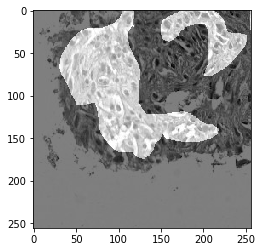

In [92]:
import matplotlib.pyplot as plt
img = np.floor(X_data[4028,:,:,0] * 255)
gt  = Y_data[4028,:,:,0] * 255
plt.imshow(img, cmap='gray')
plt.imshow(gt, cmap='gray', alpha = 0.5)
plt.show()

In [10]:
def adjustData(img, mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

In [29]:
import os
import os
import glob
import numpy as np 
from PIL import Image

img_paths = [val_images + id for id in os.listdir(val_images)]
img_paths.sort()
X_val = np.array([np.asarray(Image.open(path)) for path in img_paths])

img_paths = [val_mask + id for id in os.listdir(val_mask)]
img_paths.sort()
Y_val = np.array([np.asarray(Image.open(path)) for path in img_paths])
Y_val = Y_val[:,:,:,np.newaxis]
X_val = X_val / 255.

## ONLINE GENERATORS (No usar)

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Image data generator distortion options
data_gen_args = dict(rotation_range=45.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')  #use 'constant'??


# Runtime data augmentation
def flow_images(X, Y, batch_size=100, seed=None, data_gen_args=None):
        
    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    if data_gen_args:
        X_datagen = ImageDataGenerator(**data_gen_args)
        Y_datagen = ImageDataGenerator(**data_gen_args)
    else:
        X_datagen = ImageDataGenerator()
        Y_datagen = ImageDataGenerator()
    
    X_datagen.fit(X, augment=True, seed=seed)
    Y_datagen.fit(Y, augment=True, seed=seed)
    X_generator = X_datagen.flow(X, batch_size=batch_size, shuffle=True, seed=seed)
    Y_generator = Y_datagen.flow(Y, batch_size=batch_size, shuffle=True, seed=seed)
    
    # combine generators into one which yields image and masks
    generator = zip(X_generator, Y_generator)
    return generator




Using TensorFlow backend.


# Directory Generator

In [3]:
from keras.preprocessing.image import ImageDataGenerator

def flow_images_dir(batch_size, train_path, image_folder, mask_folder, 
                   aug_dict = None, 
                   image_color_mode = "rgb",
                   mask_color_mode = "grayscale", 
                   image_save_prefix  = "image", 
                   mask_save_prefix  = "mask",
                   save_to_dir = None, 
                   target_size = (256, 256),
                   seed = seed):
    
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    if aug_dict:
        image_datagen = ImageDataGenerator(**aug_dict)
        mask_datagen = ImageDataGenerator(**aug_dict)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
                                                    train_path,
                                                    classes = [image_folder],
                                                    class_mode = None,
                                                    color_mode = image_color_mode,
                                                    target_size = target_size,
                                                    batch_size = batch_size,
                                                    save_to_dir = save_to_dir,
                                                    save_prefix  = image_save_prefix,
                                                    seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
                                                    train_path,
                                                    classes = [mask_folder],
                                                    class_mode = None,
                                                    color_mode = mask_color_mode,
                                                    target_size = target_size,
                                                    batch_size = batch_size,
                                                    save_to_dir = save_to_dir,
                                                    save_prefix  = mask_save_prefix,
                                                    seed = seed)
    
    generator = zip(image_generator, mask_generator)
    for (img, mask) in generator:
        img = img / 255.
    #    #msk = msk[:,:,:,np.newaxis]
        yield (img, mask)


Using TensorFlow backend.


## LOSS FUNCTION

In [4]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


## U-NET MODEL

In [5]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import callbacks
import keras

# Design our model architecture here
def unet_model(img_width=256, img_height=256):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    '''
    n_ch_exps = [4, 5, 6, 7, 8, 9]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    n_ch_exps = [4, 5, 6, 7, 8]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256

    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer

    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (3, img_width, img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width, img_height, 3)

    inp = Input(shape=input_shape)
    encodeds = []

    # encoder
    enc = inp
    print(n_ch_exps)
    for l_idx, n_ch in enumerate(n_ch_exps):
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        enc = Dropout(0.1*l_idx,)(enc)
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        encodeds.append(enc)
        #print(l_idx, enc)
        if n_ch < n_ch_exps[-1]:  #do not run max pooling on the last encoding/downsampling step
            enc = MaxPooling2D(pool_size=(2,2))(enc)
    
    # decoder
    dec = enc
    print(n_ch_exps[::-1][1:])
    decoder_n_chs = n_ch_exps[::-1][1:]
    for l_idx, n_ch in enumerate(decoder_n_chs):
        l_idx_rev = len(n_ch_exps) - l_idx - 2  #
        dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = concatenate([dec, encodeds[l_idx_rev]], axis=ch_axis)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = Dropout(0.1*l_idx)(dec)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)

    outp = Conv2DTranspose(filters=1, kernel_size=k_size, activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(dec)

    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [14]:
# Set some model compile parameters
optimizer = 'adam'
loss      = dice_coef_loss
metrics   = [dice_coef]
num_gpus = 1

# Compile our model
model = unet_model(img_width=256, img_height=256)
model.summary()

# For more GPUs
if num_gpus > 1:
    model = multi_gpu_model(model, gpus=num_gpus)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[4, 5, 6, 7, 8]
[7, 6, 5, 4]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 256, 256, 16) 0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 16) 2320        dropout_12[0][0]                 
________________________________________________________________________________

In [4]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import callbacks
from keras import backend as K
import keras

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

  
def unet(pretrained_weights = None, input_size = (256,256,3)):
    
    inputs = Input(input_size)
    
    # Implementar un U-Net que tenga:
    # - Relu como función de activación
    # - 4 niveles de MaxPooling de 2x2
    # - Que utilice 'he' como método de incialización de pesos: kernel_initializer = 'he_normal'
    
    
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    #por que cambia el kernel de 2 a 3
    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    out = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(input = inputs, output = out )

    # Compilar el modelo usando Adam como algoritmo de optimización, con learning rate = 1e-5
    model.compile(optimizer = Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    
    print(model.summary())

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    print("Model created")
    return model

Flow from memory (no usar)

In [15]:
BATCH_SIZE = 50

data_gen_args = dict(rotation_range=2., 
                    #width_shift_range=0.05,
                    #height_shift_range=0.05,
                    shear_range=0.05,
                    #zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect',
                    )


train_gen = flow_images(X_data, Y_data, batch_size=BATCH_SIZE, data_gen_args=data_gen_args, seed=seed)

val_gen = flow_images(X_val, Y_val, batch_size=BATCH_SIZE, data_gen_args=None, seed=seed)

lenght = len(X_data)

NameError: name 'flow_images' is not defined

In [5]:
BATCH_SIZE = 50

data_gen_args = dict(rotation_range=2., 
                    #width_shift_range=0.05,
                    #height_shift_range=0.05,
                    shear_range=0.05,
                    #zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect',
                    )


#train_gen = flow_images(X_data, Y_data, batch_size=BATCH_SIZE, data_gen_args=data_gen_args, seed=seed)

# Generador para los datos de training
train_gen = flow_images_dir(BATCH_SIZE, 
                            train_path  ='/home/ec2-user/SageMaker/project/ACDC/',
                           image_folder = 'train_image',
                           mask_folder  = 'train_mask',
                           aug_dict  = data_gen_args, 
                           # aug_dict  = None, 
                           save_to_dir = None, 
                           target_size = (256, 256))

# Generador para los datos de validation
val_gen = flow_images_dir(BATCH_SIZE, 
                            train_path  ='/home/ec2-user/SageMaker/project/ACDC/',
                           image_folder = 'val_image',
                           mask_folder  = 'val_mask',
                           aug_dict  = None, 
                           save_to_dir = None, 
                           target_size = (256, 256))

train_lenght = 196933
val_lenght = 30929

In [6]:
model = unet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [11]:
model = keras.models.load_model('unet_9capas.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef})


In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
callbacks_list = [ ModelCheckpoint('unet_9capas_2ndtrain.hdf5', monitor='val_loss', verbose=1, save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1, ),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)]


history = model.fit_generator(train_gen, 
                              verbose=1,
                              steps_per_epoch = int(np.floor(train_lenght/BATCH_SIZE)), 
                              epochs=1000,
                              callbacks = callbacks_list,
                              validation_data = val_gen, 
                              validation_steps= int(np.floor(val_lenght/BATCH_SIZE))
                             )


Epoch 1/1000
3938/3938 [==============================] - 18218s 5s/step - loss: -0.6294 - dice_coef: 0.6294 - val_loss: -0.6389 - val_dice_coef: 0.6389

Epoch 00001: val_loss improved from inf to -0.63894, saving model to unet_9capas_2ndtrain.hdf5
Epoch 2/1000
3938/3938 [==============================] - 10194s 3s/step - loss: -0.6370 - dice_coef: 0.6370 - val_loss: -0.5981 - val_dice_coef: 0.5981

Epoch 00002: val_loss did not improve from -0.63894
Epoch 3/1000
3938/3938 [==============================] - 10105s 3s/step - loss: -0.6455 - dice_coef: 0.6455 - val_loss: -0.6124 - val_dice_coef: 0.6124

Epoch 00003: val_loss did not improve from -0.63894

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 4/1000
3938/3938 [==============================] - 10212s 3s/step - loss: -0.6541 - dice_coef: 0.6541 - val_loss: -0.6610 - val_dice_coef: 0.6610

Epoch 00004: val_loss improved from -0.63894 to -0.66099, saving model to unet_9capas_2ndtrain.hdf5
Epoc

In [ ]:
history

In [11]:
import matplotlib.pyplot as plt

def plotResults(history, metrics='acc'):
        plt.style.use('seaborn')
        acc = history.history[metrics]
        val_acc = history.history['val_'+ metrics]
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure()
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

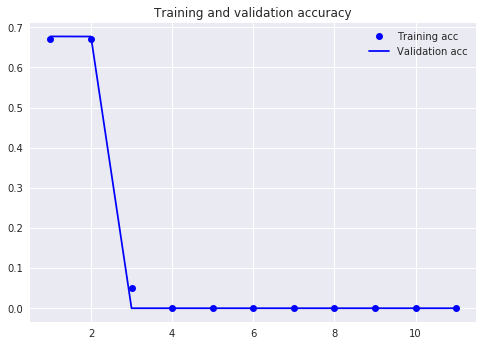

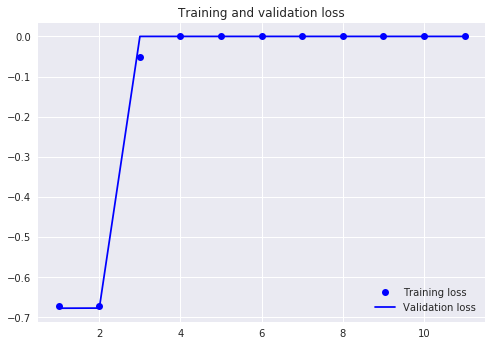

In [12]:
plotResults(history, 'dice_coef')

In [48]:
x = np.asarray([x.mean() for x in Y_val[:,:,:]])
x.sort()
x

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

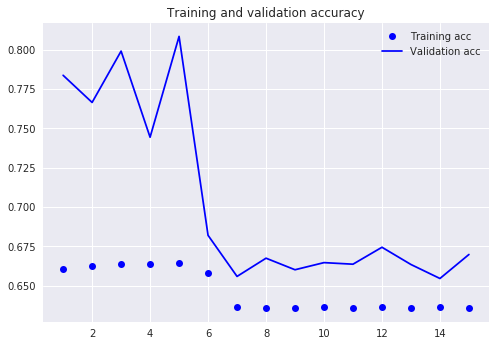

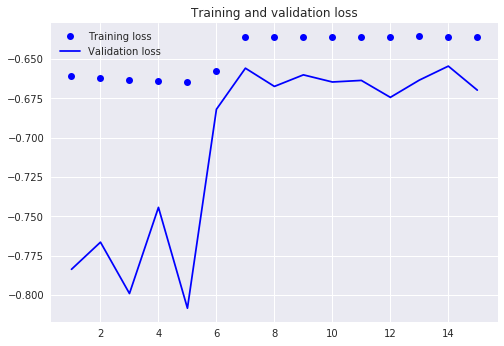

In [10]:
plotResults(history, 'dice_coef')

# Testing the Generator process

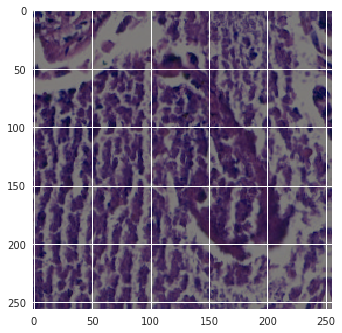

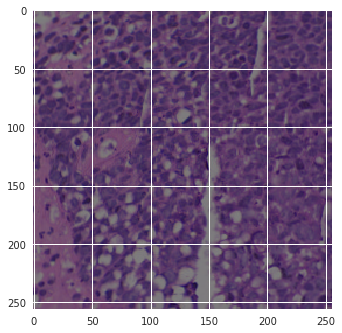

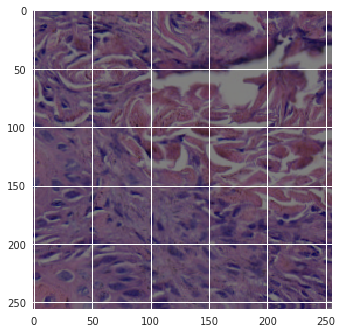

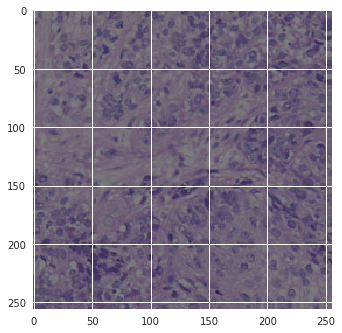

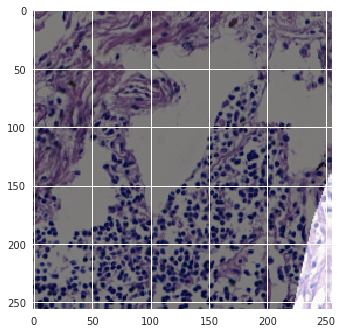

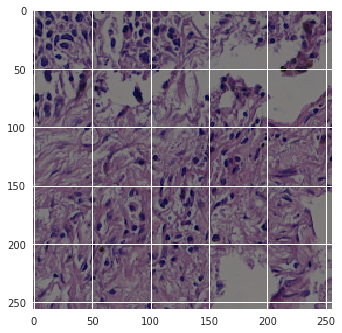

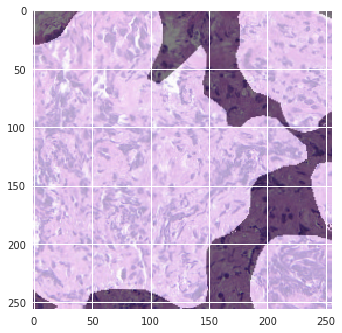

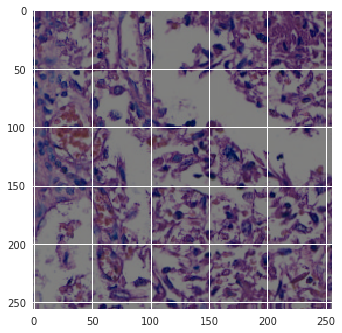

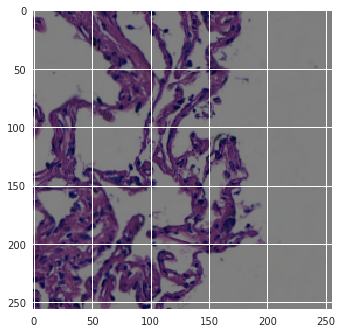

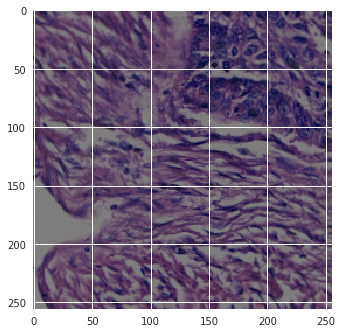

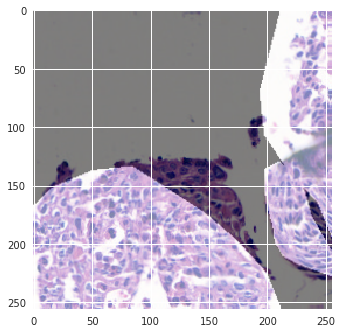

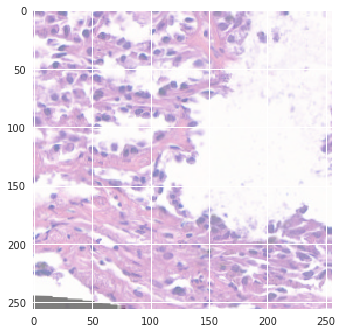

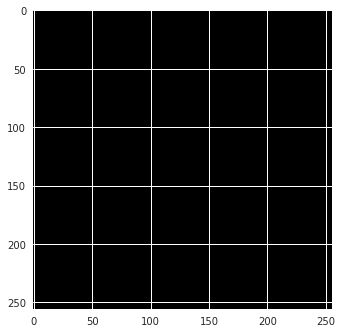

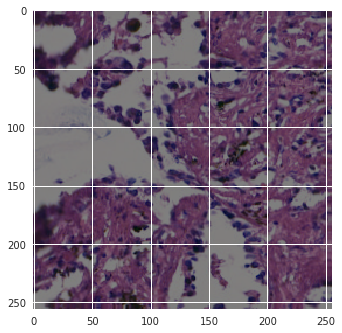

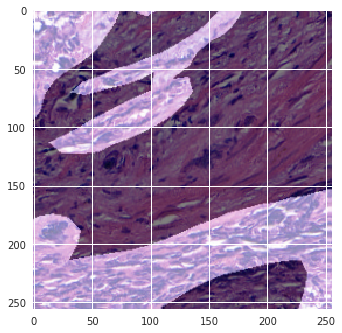

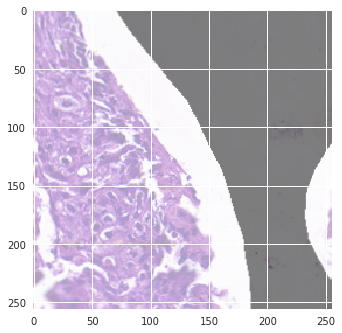

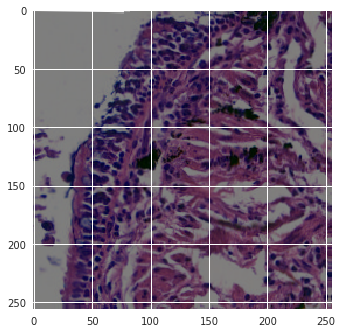

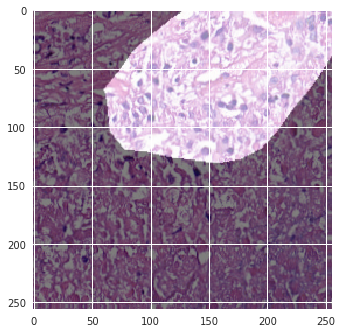

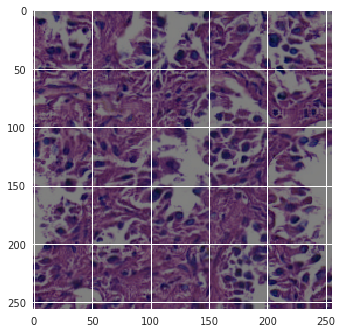

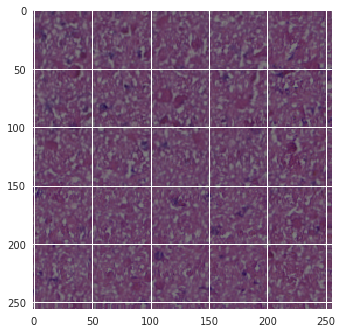

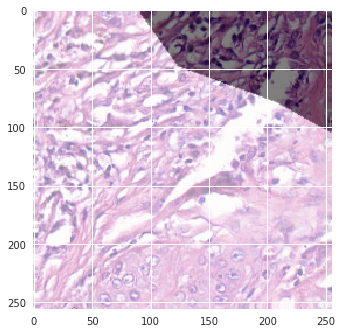

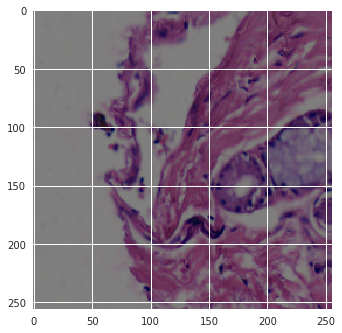

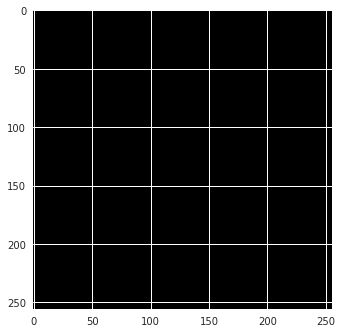

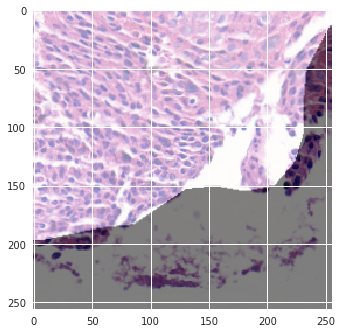

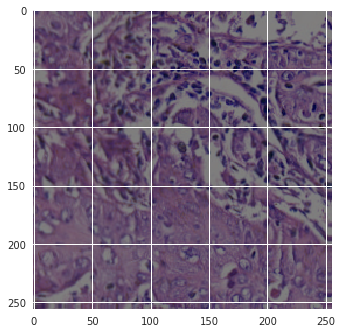

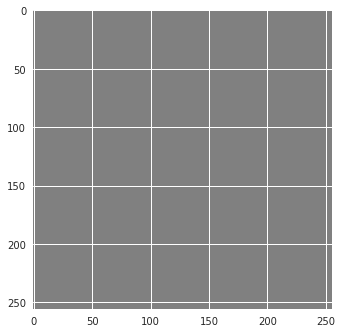

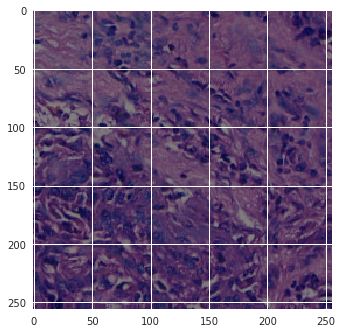

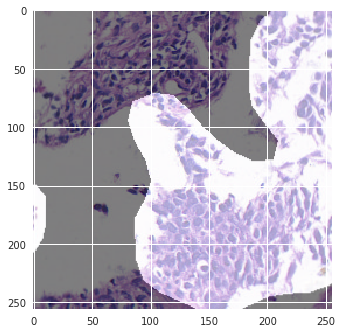

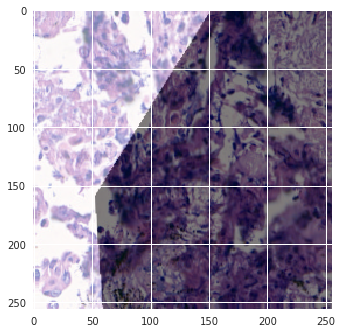

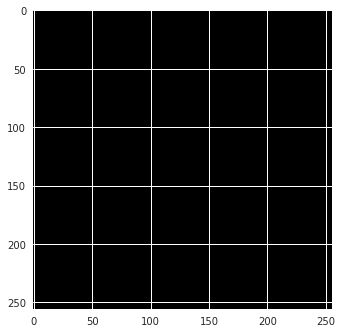

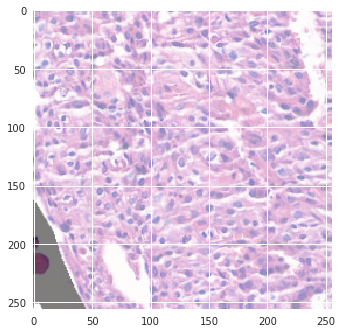

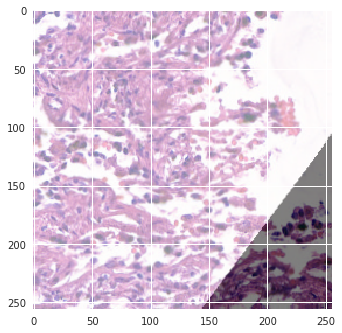

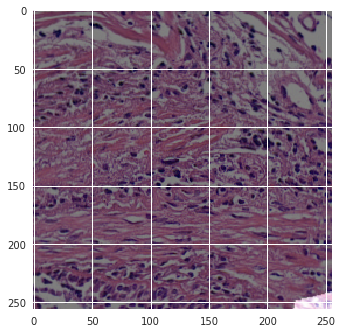

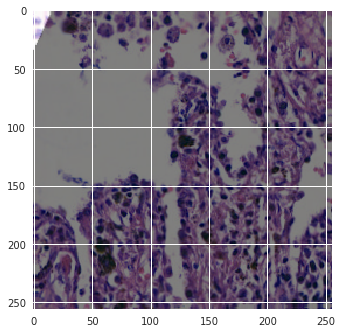

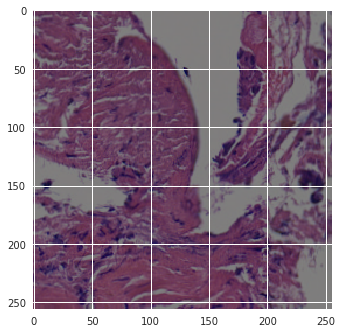

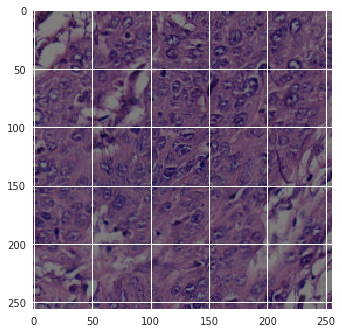

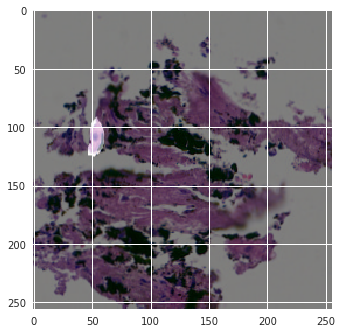

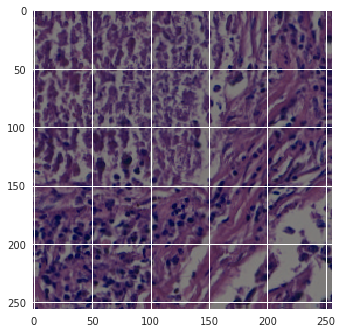

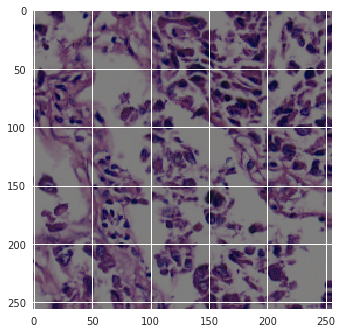

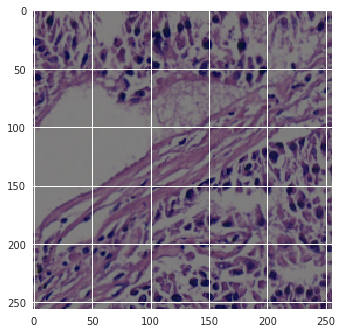

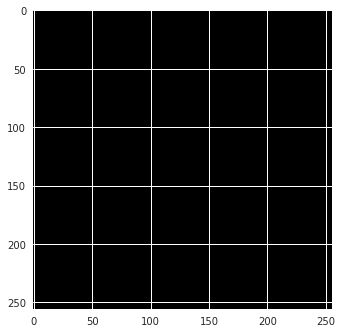

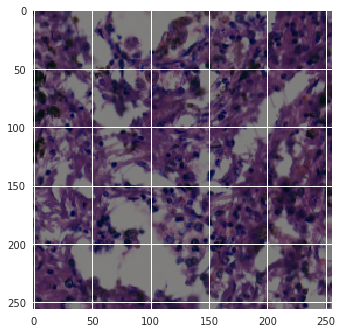

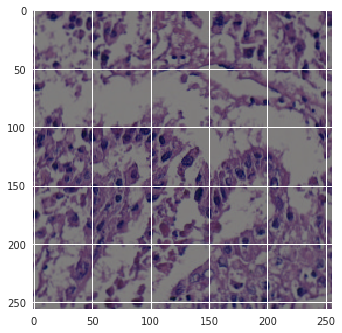

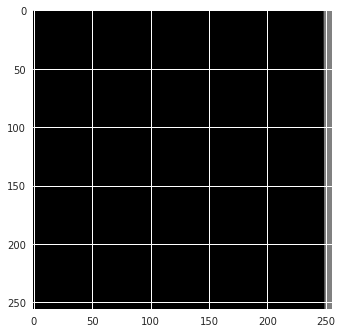

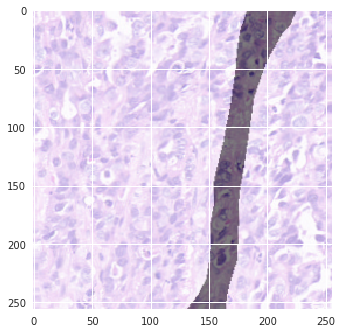

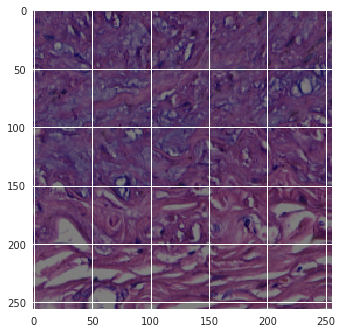

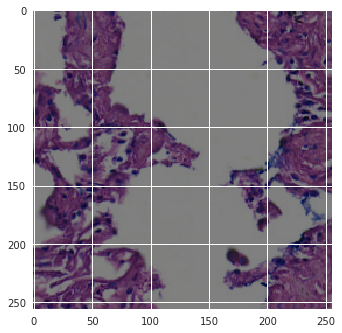

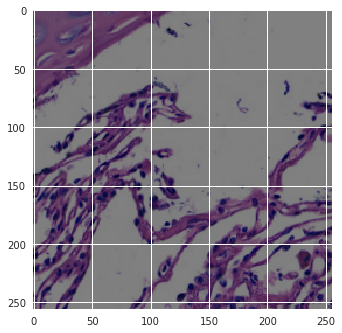

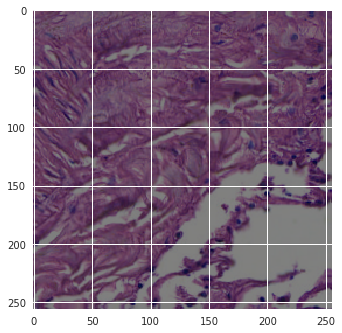

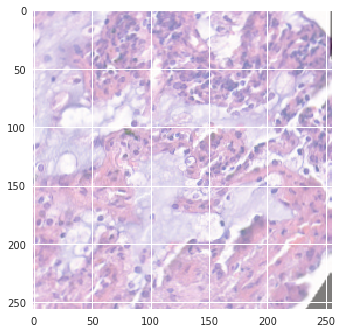

In [67]:
from PIL import Image

num_batch = 1
for i, batch in enumerate(train_gen):
    if(i >= num_batch):
        break

for i in range(batch[0].shape[0]):
    plt.imshow(batch[0][i][:,:,:])
    plt.imshow(batch[1][i][:,:,0] * 250, cmap='gray', alpha=0.5)
    plt.show()
    #batch[0][i][:,:,:] 
    
    
#for i in range(batch[0].shape[0]):
#    plt.imshow(batch[1][i][:,:,0])
#    plt.imshow(batch[0][i][:,:,0]*250, cmap='gray',alpha=0.5)
#    plt.show()

In [64]:
batch[0][i][:,:,:]

array([[[0.47843137, 0.34509805, 0.7372549 ],
        [0.37254903, 0.2784314 , 0.6509804 ],
        [0.3254902 , 0.18431373, 0.61960787],
        ...,
        [0.81960785, 0.6784314 , 0.8156863 ],
        [0.92156863, 0.827451  , 0.9254902 ],
        [1.        , 0.99607843, 0.9647059 ]],

       [[0.91764706, 0.7529412 , 0.8235294 ],
        [0.8392157 , 0.7254902 , 0.8627451 ],
        [0.7254902 , 0.69803923, 0.8352941 ],
        ...,
        [0.654902  , 0.41960785, 0.7058824 ],
        [0.8352941 , 0.69411767, 0.8156863 ],
        [0.9411765 , 0.8862745 , 0.8666667 ]],

       [[0.68235296, 0.4627451 , 0.78039217],
        [0.8745098 , 0.75686276, 0.8509804 ],
        [0.9529412 , 0.8862745 , 0.9254902 ],
        ...,
        [0.67058825, 0.40392157, 0.7254902 ],
        [0.84313726, 0.59607846, 0.80784315],
        [0.84313726, 0.6392157 , 0.81960785]],

       ...,

       [[0.85882354, 0.78431374, 0.9019608 ],
        [0.9019608 , 0.75686276, 0.84705883],
        [0.972549  , 0

# Loading model

In [10]:
from PIL import Image
from PIL import ImageFile
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
unet_l4_200m = keras.models.load_model('unet_4capas_200mil.hdf5',custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef})

In [25]:
path = './val_image/img1010img_patch10001.tif'
image = np.asarray(Image.open(path))
path = './val_mask/img1010msk_patch10001.tif'
mask = np.asarray(Image.open(path))

In [22]:
X_batch = image[np.newaxis, :,:,:]/255.

In [26]:
pred_mask = unet_l4_200m.predict(X_batch)

In [27]:
pred_mask.mean(), mask.mean()

(1.0, 0.268768310546875)